Traditional models for image to image translation (and computer vision in general) use per-pixel loss functions. However, the per-pixel losses used by these methods do not capture perceptual differences between output and ground-truth images. For example, consider two identical images offset from each other by one pixel; despite their perceptual similarity they would be very different as measured by per-pixel losses. Recent work has shown that high-quality images can be generated using perceptual loss functions based not on differences between pixels but instead on differences between high-level image feature representations extracted from pretrained convolutional neural networks (example: VGG16). During training, perceptual losses measure image similarities more robustly than per-pixel losses, and at test-time the transformation networks run in real-time.

<br>The Perceptual loss model has been shown to be helpful for two tasks: style transfer and single-image super-resolution. Both are inherently ill-posed; for style transfer there is no single correct output, and for super-resolution there are many high-resolution images that could have generated the same low-resolution input. Success in either task requires semantic reasoning about the input image. For style transfer the output must be semantically similar to the input despite drastic changes in color and texture; for superresolution fine details must be inferred from visually ambiguous low-resolution inputs.
<br>
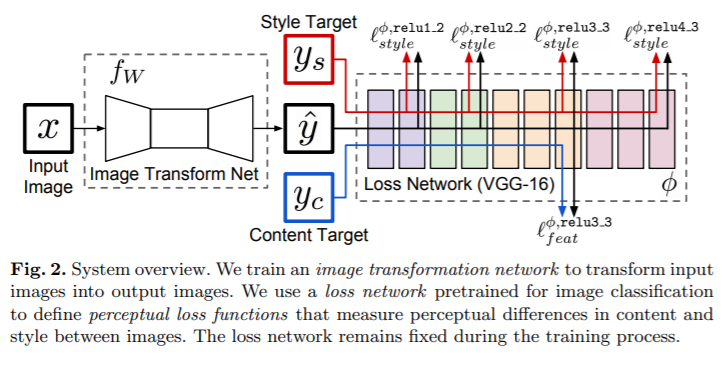
<br> Reference paper: https://arxiv.org/pdf/1603.08155.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
netVGG = torchvision.models.vgg16()
mod = nn.Sequential(*list(netVGG.features.children())[:-1])

In [3]:
torchvision.models.vgg16().features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [2]:
#Ref: https://github.com/dxyang/StyleTransfer/blob/master/vgg.py
class VGGPerceptualLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        model = torchvision.models.vgg16(pretrained=True)
        features = model.features
        self.relu1_2 = nn.Sequential()
        self.relu2_2 = nn.Sequential()
        self.relu3_3 = nn.Sequential()
        self.relu4_3 = nn.Sequential()
        for i in range(4):
            self.relu1_2.add_module(name="relu1_2_"+str(i+1), module=features[i])
        for i in range(4, 9):
            self.relu2_2.add_module(name="relu2_2_"+str(i-3), module=features[i])
        for i in range(9, 16):
            self.relu3_3.add_module(name="relu3_3_"+str(i-8), module=features[i])
        for i in range(16, 23):
            self.relu4_3.add_module(name="relu4_3_"+str(i-15), module=features[i])      
        # Setting requires_grad=False to fix the perceptual loss model parameters 
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        out_relu1_2 = self.relu1_2(x)
        out_relu2_2 = self.relu2_2(out_relu1_2)
        out_relu3_3 = self.relu3_3(out_relu2_2)
        out_relu4_3 = self.relu4_3(out_relu3_3)
        return out_relu1_2, out_relu2_2, out_relu3_3, out_relu4_3

In [4]:
loss = VGGPerceptualLoss()

In [ ]:
loss  # Displaying the different layers (grouped in submodules) in the loss module

In [ ]:
# Displaying the various parameters in the loss module
for name_str, param in loss.named_parameters():
    print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))

In [48]:
inp = torch.randn(10,3,256,256)

In [49]:
out = loss(inp)

In [50]:
for i in range(4):
    print(out[i].shape)

torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])


In [51]:
# Function to calculate Gram matrix
def gram(x):
    (N, C, H, W) = x.shape
    psy = x.view(N, C, H*W)
    psy_T = psy.transpose(1, 2)
    G = torch.bmm(psy, psy_T) / (C*H*W)  # Should we divide by N here? Or does batch matric multiplication do that on it's own? 
    return G

In [74]:
def TotalPerceptualLoss(x, y_hat, y_s):
    
    VGGLoss = VGGPerceptualLoss()  # Creating an instance of the VGG Perceptual Loss class (This should be global as this is a slow instantiation)
    mse_loss = nn.MSELoss() # Should be global as well
    y_c_features = VGGLoss(x) # y_c = x
    y_hat_features = VGGLoss(y_hat)
    y_s_features = VGGLoss(y_s)
    
    # Calculating content loss
    C = y_hat_features[2].shape[1]
    H = y_hat_features[2].shape[2]
    W = y_hat_features[2].shape[3]
    content_loss = mse_loss(y_hat_features[2], y_c_features[2]) / (C*H*W)  # Use index 2 since we only use feature reconstruction loss and not the style reconstruction loss
    # Also here assuming square of Euclidean Norm = MSE Loss
    
    # Calculating Style loss
    style_loss = 0.0
    for i in range(4):
        style_loss += mse_loss(gram(y_hat_features[i]), gram(y_s_features[i]))
    
    total_loss = STYLE_WEIGHT*style_loss + CONTENT_WEIGHT*content_loss
    return total_loss

In [77]:
# Note: Total Variation Regularization not implemented
# Implementing the Perceptual Loss
x = torch.randn(4,3,256,256)  # Batch Size = 4
y_hat = torch.randn(4,3,256,256)  # We get this from the image transformation network
y_s = torch.randn(4,3,256,256)
CONTENT_WEIGHT = 1.0
STYLE_WEIGHT = 1.0
loss = TotalPerceptualLoss(x, y_hat, y_s)

In [78]:
loss

tensor(1.1034e-05)